# Churn Prediction Model for Beta Bank

This project aims to determine the best model to predict the churning rate for Beta Bank, so bankers can save the existing customers rather than attract new ones to improve long-term sustainability for the company.

## Initialization

In [5]:
#Loading Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# from imblearn.over_sampling import SMOTE
# from joblib import dump
# import joblib
import warnings
warnings.filterwarnings("ignore")

### Data Exploration

In [3]:
# Read dataframe
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [4]:
# Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# Convert all columns string to lower case
df.columns = df.columns.str.lower()

In [6]:
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Dataframe contained 13 columns with 1 of the column contained some missing values. 

    RowNumber — data string index
    CustomerId — unique customer identifier
    Surname — surname
    CreditScore — credit score
    Geography — country of residence
    Gender — gender
    Age — age
    Tenure — period of maturation for a customer’s fixed deposit (years)
    Balance — account balance
    NumOfProducts — number of banking products used by the customer
    HasCrCard — customer has a credit card
    IsActiveMember — customer’s activeness
    EstimatedSalary — estimated salary

### Preprocessing Data

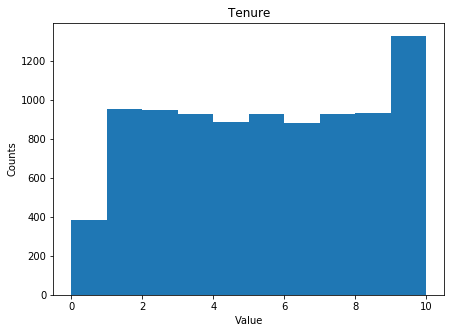

In [7]:
# Histogram for Tenure column
df['tenure'].plot.hist(figsize=(7, 5))
plt.title('Tenure')
plt.xlabel('Value')
plt.ylabel('Counts')
df['tenure'].value_counts();

#### Fill Missing Values

In [8]:
# Fill tenure missing values group by products
df['tenure']=df.groupby('numofproducts')['tenure'].apply(lambda x: x.fillna(x.mean()))

In [9]:
# Recheck for missing values
df.isna().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

In [10]:
# Drop unrelevant columns for modeling
df2 = df.drop(['rownumber','customerid','surname'], axis =1)
df2.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Fill Missing values**

Overall values count on Tenure seems balanced across the data frame. Missing values on Tenure columns have been filled group by `numofproducts`. `['rownumber','customerid','surname']` columns were dropped due to irrelevant to model training. 

#### One Hot Encoding

In [11]:
# OHE on dataframe for geography and gender
df_ohe = pd.get_dummies(df2,drop_first=True)
df_ohe.columns = df_ohe.columns.str.lower() 
df_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [12]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   numofproducts      10000 non-null  int64  
 5   hascrcard          10000 non-null  int64  
 6   isactivemember     10000 non-null  int64  
 7   estimatedsalary    10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_germany  10000 non-null  uint8  
 10  geography_spain    10000 non-null  uint8  
 11  gender_male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


#### Splitting Data Set for Training, Validation, and Testing

In [13]:
# Splitting dataframe for training, validating, and testing
target = df_ohe['exited']
features = df_ohe.drop('exited', axis=1)
features_train_full, features_test, target_train_full, target_test = \
train_test_split(features, target, test_size=0.2, random_state=12345)
features_train, features_valid,target_train,target_valid = \
train_test_split(features_train_full,target_train_full, test_size=0.25, random_state=12345)

In [14]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)


In [15]:
# Prepare numeric column for scaling
numeric = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']

In [16]:
# Scaling dataframe
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [17]:
# Check Scaled data
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_germany,geography_spain,gender_male
492,-0.134048,-0.078068,-0.368988,0.076163,2,0,1,0.331571,0,0,0
6655,-1.010798,0.494555,-0.020454,0.136391,1,1,1,-0.727858,0,0,1
4287,0.639554,1.353490,-1.454074,0.358435,1,1,1,-0.477006,1,0,1
42,-0.990168,2.116987,-1.092379,0.651725,1,1,1,-0.100232,0,0,0
8178,0.567351,0.685430,0.716098,0.813110,2,1,1,0.801922,0,0,0


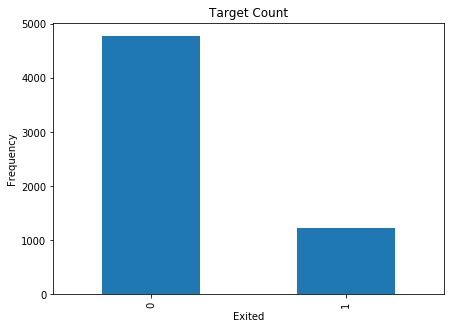

In [18]:
pd.value_counts(target_train).plot.bar(figsize=(7, 5))
plt.title('Target Count')
plt.xlabel('Exited')
plt.ylabel('Frequency')
target_train.value_counts();

**OHE on categorial features** 
  

One Hot Encoding feature was used to transform categorical features of columns `geography` and `gender` into numerical features. First, the data frame was split into 80% Training Set and 20% Test set, then 25% validation set were split from the training set. Training sets were then scaled with the Standard Scaler feature to standardize features to facilitate the training of models by algorithms. 

### Base Model

#### LR

In [19]:
# Training base model with Logistic Regression
model_lr = LogisticRegression(random_state=12345,solver='liblinear')
model_lr.fit(features_train,target_train)
predicted_valid = model_lr.predict(features_valid)
print(f1_score(target_valid,predicted_valid))

0.30131826741996237


In [20]:
# ROC curve function for plotting (feature(x),target(y),model(m))
def rocplot(x,y,m):
    probabilities_valid = m.predict_proba(x)[:,1]
    fpr, tpr, thresholds = roc_curve(y,probabilities_valid)
    print("ROC/AUC: {}".format(roc_auc_score(y, probabilities_valid)))# < write code here >
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1.0])
    plt.ylim([0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show();

#### DT

In [21]:
# Training base model with Decision Tree Classifier
dt_depth = pd.DataFrame(columns=['depth','f1'])
for depth in range (1,10):
    model_dt = DecisionTreeClassifier(max_depth=depth,random_state=12345)
    model_dt.fit(features_train,target_train)
    predictions_valid = model_dt.predict(features_valid)
    dt_depth = dt_depth.append({'depth': depth,'f1': f1_score(target_valid,predictions_valid)}, ignore_index=True)
print(f"max_depth is {dt_depth['depth'][dt_depth.f1.idxmax()]}; with highest F1 score of {dt_depth.f1.max()}")

max_depth is 7.0; with highest F1 score of 0.5583596214511041


#### RF

In [22]:
# Training base model with Random Forest Classifier
ft_depth = pd.DataFrame(columns=['n','f1'])
for n in range (5,25):
    model_ft = RandomForestClassifier(max_depth=7,n_estimators=n,random_state=12345)
    model_ft.fit(features_train,target_train)
    predictions_valid = model_ft.predict(features_valid)
    ft_depth = ft_depth.append({'n': n,'f1': f1_score(target_valid,predictions_valid)}, ignore_index=True)
print(f"max n is {ft_depth['n'][ft_depth.f1.idxmax()]}; with highest F1 score of {ft_depth.f1.max()}")

max n is 16.0; with highest F1 score of 0.5348837209302326


#### Best Base Model

In [23]:
# Best base model for dataframe
model_dt = DecisionTreeClassifier(max_depth=7,random_state=12345)
model_dt.fit(features_train,target_train)
predictions_valid = model_dt.predict(features_valid)
print('f1 score:',f1_score(target_valid,predictions_valid))

f1 score: 0.5583596214511041


ROC/AUC: 0.8231010349393358


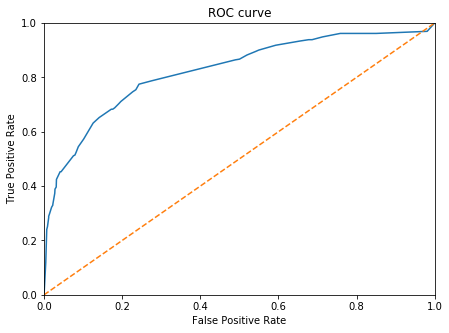

In [24]:
# ROC plotting and Area under curve
rocplot(features_valid, target_valid,model_dt)

### Class Weight Balanced Model

#### LR_CWB

In [25]:
# Training base model with Logistic Regression with class_weight balanced parameters
model_lr_cwb = LogisticRegression(random_state=12345,solver='liblinear',class_weight='balanced')
model_lr_cwb.fit(features_train,target_train)
predicted_valid = model_lr_cwb.predict(features_valid)
print('f1 score:',f1_score(target_valid,predicted_valid))

f1 score: 0.4741532976827095


#### DT_CWB

In [26]:
# Training base model with Decision Tree Classifier with class_weight balanced parameters
dt_depth = pd.DataFrame(columns=['depth','f1'])
for depth in range (1,10):
    model_dt = DecisionTreeClassifier(max_depth=depth,random_state=12345,class_weight='balanced')
    model_dt.fit(features_train,target_train)
    predictions_valid = model_dt.predict(features_valid)
    dt_depth = dt_depth.append({'depth': depth,'f1': f1_score(target_valid,predictions_valid)}, ignore_index=True)
print(f"max_depth is {dt_depth['depth'][dt_depth.f1.idxmax()]}; with highest F1 score of {dt_depth.f1.max()}")

max_depth is 6.0; with highest F1 score of 0.5587044534412956


#### RF_CWB

In [27]:
# Training base model with Random Forest Classifier with class_weight balanced parameters
ft_depth = pd.DataFrame(columns=['n','f1'])
for n in range (90,95):
    model_ft = RandomForestClassifier(max_depth=6,n_estimators=n,random_state=12345,class_weight='balanced')
    model_ft.fit(features_train,target_train)
    predictions_valid = model_ft.predict(features_valid)
    ft_depth = ft_depth.append({'n': n,'f1': f1_score(target_valid,predictions_valid)}, ignore_index=True)
print(f"max n is {ft_depth['n'][ft_depth.f1.idxmax()]}; with highest F1 score of {ft_depth.f1.max()}")

max n is 92.0; with highest F1 score of 0.5818965517241379


#### Best Model_RF_CWB

In [28]:
# Best model with class_weight balanced parameters
model_rf_cwb = RandomForestClassifier(max_depth=6,n_estimators=92,random_state=12345,class_weight='balanced')
model_rf_cwb.fit(features_train,target_train)
predictions_valid = model_rf_cwb.predict(features_valid)
print('f1 score:',f1_score(target_valid,predictions_valid))

f1 score: 0.5818965517241379


ROC/AUC: 0.8484070581241387


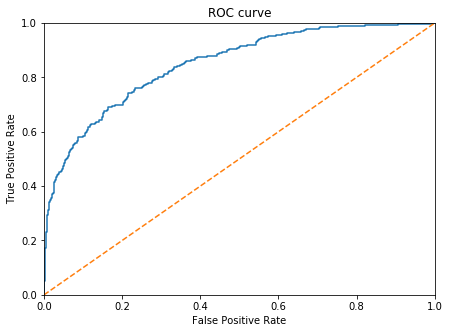

In [29]:
# ROC plotting and Area under curve
rocplot(features_valid,target_valid,model_rf_cwb)

### SMOTE Resampled Model

#### Resampling Undersize Model

In [30]:
# SMOTE to resampling data
sm = SMOTE(random_state=12345)
features_train_r, target_train_r = sm.fit_resample(features_train, target_train)

In [31]:
# Without SMOTE
target_train.value_counts()

0    4781
1    1219
Name: exited, dtype: int64

In [32]:
# After SMOTE
target_train_r.value_counts()

0    4781
1    4781
Name: exited, dtype: int64

#### LR_SMOTE

In [33]:
# Training SMOTE resampled data model with Logistic Regression
model_lr_smote = LogisticRegression(random_state=12345,solver='liblinear')
model_lr_smote.fit(features_train_r,target_train_r)
predicted_valid = model_lr_smote.predict(features_valid)
print(f1_score(target_valid,predicted_valid))

0.4860853432282004


#### DT_SMOTE

In [34]:
# Training SMOTE resampled data model with Decision Tree Classifier
dt_depth = pd.DataFrame(columns=['depth','f1'])
for depth in range (1,10):
    model_dt = DecisionTreeClassifier(max_depth=depth,random_state=12345)
    model_dt.fit(features_train_r,target_train_r)
    predictions_valid = model_dt.predict(features_valid)
    dt_depth = dt_depth.append({'depth': depth,'f1': f1_score(target_valid,predictions_valid)}, ignore_index=True)
print(f"max_depth is {dt_depth['depth'][dt_depth.f1.idxmax()]}; with highest F1 score of {dt_depth.f1.max()}")

max_depth is 5.0; with highest F1 score of 0.5443169968717414


#### RF_SMOTE

In [35]:
# Training SMOTE resampled data model with Random Forest Classifier
ft_depth = pd.DataFrame(columns=['n','f1'])
for n in range (1,15):
    model_ft = RandomForestClassifier(max_depth=5,n_estimators=n,random_state=12345)
    model_ft.fit(features_train_r,target_train_r)
    predictions_valid = model_ft.predict(features_valid)
    ft_depth = ft_depth.append({'n': n,'f1': f1_score(target_valid,predictions_valid)}, ignore_index=True)
print(f"max n is {ft_depth['n'][ft_depth.f1.idxmax()]}; with highest F1 score of {ft_depth.f1.max()}")

max n is 11.0; with highest F1 score of 0.5757906215921483


#### Best Model_RF_SMOTE

In [36]:
# Best model for SMOTE resampled
model_rf_smote = RandomForestClassifier(max_depth=5,n_estimators=11,random_state=12345)
model_rf_smote.fit(features_train_r,target_train_r)
predictions_valid = model_rf_smote.predict(features_valid)
print('f1 score:',f1_score(target_valid,predictions_valid))

f1 score: 0.5757906215921483


ROC/AUC: 0.8461872873017664


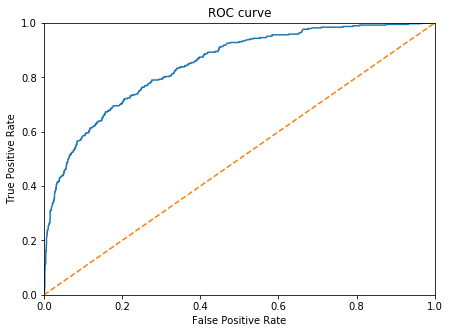

In [37]:
# ROC plotting and Area under curve
rocplot(features_valid,target_valid,model_rf_smote)

### Choosing Best Model

#### Model_RF_CWB (Best F1 Score)

In [38]:
# Scale full training set
scaler.fit(features_train_full[numeric])
features_train_full[numeric] = scaler.transform(features_train_full[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [39]:
# Best model with top F1 score and ROC-AUC score (Random Forest Classifier with Class_weight balanced parameters)
model_rf_cwb = RandomForestClassifier(max_depth=6,n_estimators=92,random_state=12345,class_weight='balanced')
model_rf_cwb.fit(features_train_full,target_train_full)
predictions_test = model_rf_cwb.predict(features_test)
print('f1 score:',f1_score(target_test,predictions_test))

f1 score: 0.6357487922705314


ROC/AUC: 0.863656462762275


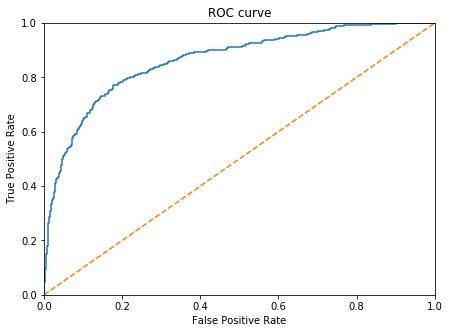

In [40]:
# ROC plotting and Area under curve
rocplot(features_test,target_test,model_rf_cwb)

## Conclusion

Models were trained with standard training set without any alteration and tested on the validation sets. Started with base model training with Logistic Regression, Decision Tree Classification, and Random Forest classification (`LR, DT, RF`). Then all models training were repeated with parameter `class_weight = balanced` added (`LR_CWB, DT_CWB, RF_CWB`). The last round of model training was performed on SMOTE resample balanced data frame (`LR_S, DT_S, RF_S`). The best depth parameters for all the Decision Tree Model were tested using the loop. Then the best-chosen parameters were used to train the Random Forest model. Best n_estimator parameters are determined using the for loops. 

  

**F1 Scores of the different model:** 

- LR = 0.301 

- DT = 0.558 

- RT = 0.535 

- LR_CWB = 0.474 

- DT_CWB = 0.559 

- RF_CWB = 0.582 

- LR_S = 0.486 

- DT_S = 0.544 

- RF_S = 0.576 

 

The final model chosen Random Forest Classification with parameters `max_depth=6, n_estimators=92, random_state=12345, class_weight='balanced'`, with top F1 Scores of 0.582, and area under curve, ROC-AOC score of 0.848. 

  

Full training sets were used to scale and fit the model. The model was then tested on the test set, achieving a final F1 score of **`0.636`** and an area under the curve, ROC-AOC score of **`0.864`**. The best model improved significantly compared to the base model, which is f1 score of 0.558 (**14%** improvement) and ROC/AUC score of 0.823`.  

  

I recommend the Beta bank use Random Forest Classification with parameters max_depth of 6, n_estimators of 92, class_weight='balanced' for churning rate prediction. 